# ２つの正規分布の混在比率・平均・標準偏差を同時に求める
- 混在比率: $p$
- 平均: $\mu$
- 標準偏差: $\sigma$

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import random
from scipy.stats import norm
from sympy.abc import delta

random.seed(42)

In [2]:
# Data 準備
df_iris = sns.load_dataset('iris')
df_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
df_others = df_iris.loc[df_iris['species']!='setosa']  # setosa 以外の２種類
df_others.reset_index(drop=True, inplace=True)
petal_widths = df_others['petal_width'].values  # X: 説明変数を設定

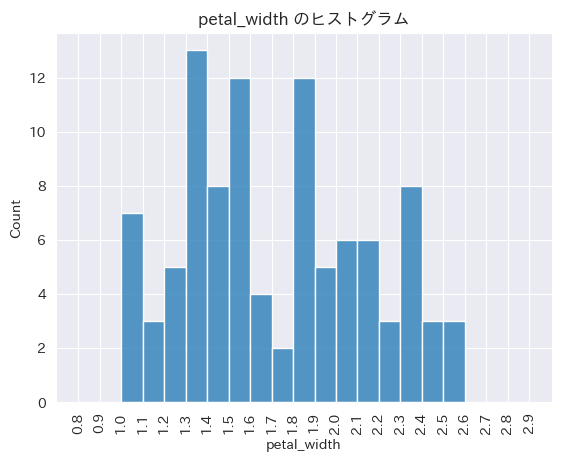

In [8]:
# 分析対象の Histgram
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(x=petal_widths, bins=bins)
ax.set_xlabel('petal_width')
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_width のヒストグラム')
ax.set_xticks(bins)
plt.show()

一見ばらついて見えるのは、２種類の花の統計データが混合しているから。

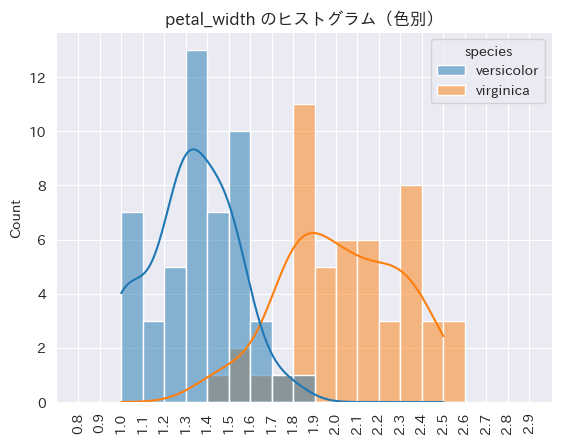

In [9]:
# 色分けしてヒストグラムを描画
fig, ax = plt.subplots()
sns.histplot(x=petal_widths, bins=bins, data=df_others, hue='species', kde=True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('petal_width のヒストグラム（色別）')
ax.set_xticks(bins)
plt.show()

２つの正規分布に従う確率変数の、混在比率と特徴を示すパラメータ（平均と標準偏差）を不明ということにして推論してみる

In [16]:
# 確率モデル定義

# 変数の初期設定
n_components = 2  # 何種類の正規分布モデルがあるか
N_ovs = petal_widths.shape  # 観測値の件数

model_latent_variables = pm.Model()

with model_latent_variables:
    # 定数
    X_petal_width = pm.ConstantData('X_petal_width', petal_widths)  # X の観測値
    # 変数
    p = pm.Uniform('p', lower=0.0, upper=1.0)  # p: 潜在変数が 1 の値をとる確率
    s = pm.Bernoulli('s', p=p, shape=N_ovs)  # s: 潜在変数 p の確率値をもとに 0, 1 いずれかの値を返す
    # 確率変数
    mus = pm.Normal('mus', mu=0.0, sigma=10.0, shape=n_components)  # mus: ２つの品種毎の平均値
    taus = pm.HalfNormal('taus', sigma=10.0,
                         shape=n_components)  # taus: ２つの品種毎のバラツキ（taus = 1 / (sigmas*sigmas)）
    sigmas = pm.Deterministic('sigmas', 1 / pm.math.sqrt(taus))  # 分析で sigmas が必要なため算出
    mu = pm.Deterministic('mu', mus[s])  # 各観測値ごとに潜在変数から mu を求める
    tau = pm.Deterministic('tau', taus[s])  # 各観測値ごとに潜在変数から tau を求める 
    # 正規分布に従う確率変数 obs の定義
    obs_x = pm.Normal('obs_x', mu=mu, tau=tau, observed=X_petal_width)

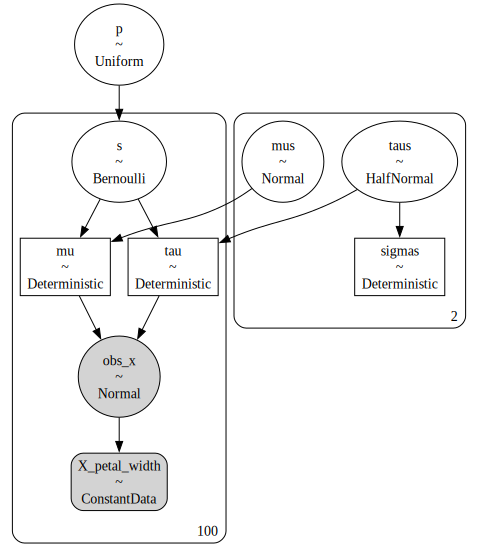

In [17]:
# 確率モデルの可視化
pm.model_to_graphviz(model_latent_variables)

In [18]:
# Sampling
with model_latent_variables:
    inference_latent_variables = pm.sample(chains=1, draws=2000, random_seed=42)
    # ラベルスイッチを防ぐため、chains=1 に設定
    # chains=1 のため、drawsを増加

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, mus, taus]
>BinaryGibbsMetropolis: [s]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 1105 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


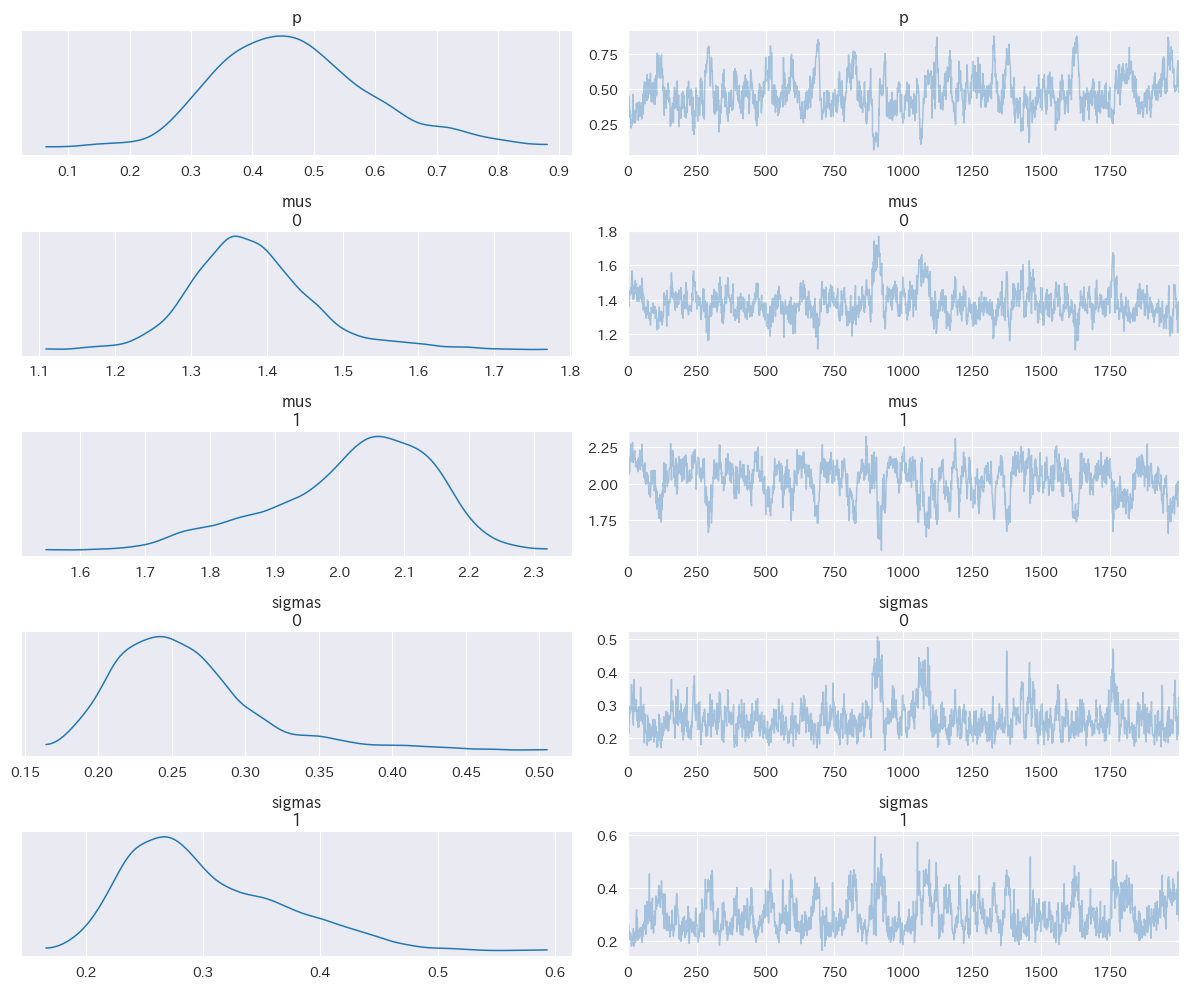

In [19]:
az.plot_trace(inference_latent_variables, var_names=['p', 'mus', 'sigmas'], compact=False)
plt.tight_layout()
plt.show()

- $p$ は 0.5 程度になるはず     
  => 分布のピークが 0.4 と 0.5 の間くらい 
- `mus[0]`: 1.2 ~ 1.6 の範囲で変化
- `mus[1]`: 1.7 ~ 2.3 の範囲で変化
- `sigma[0]`: 0.25程度を中心とした分布
- `sigma[1]`: 0.25程度を中心とした分布

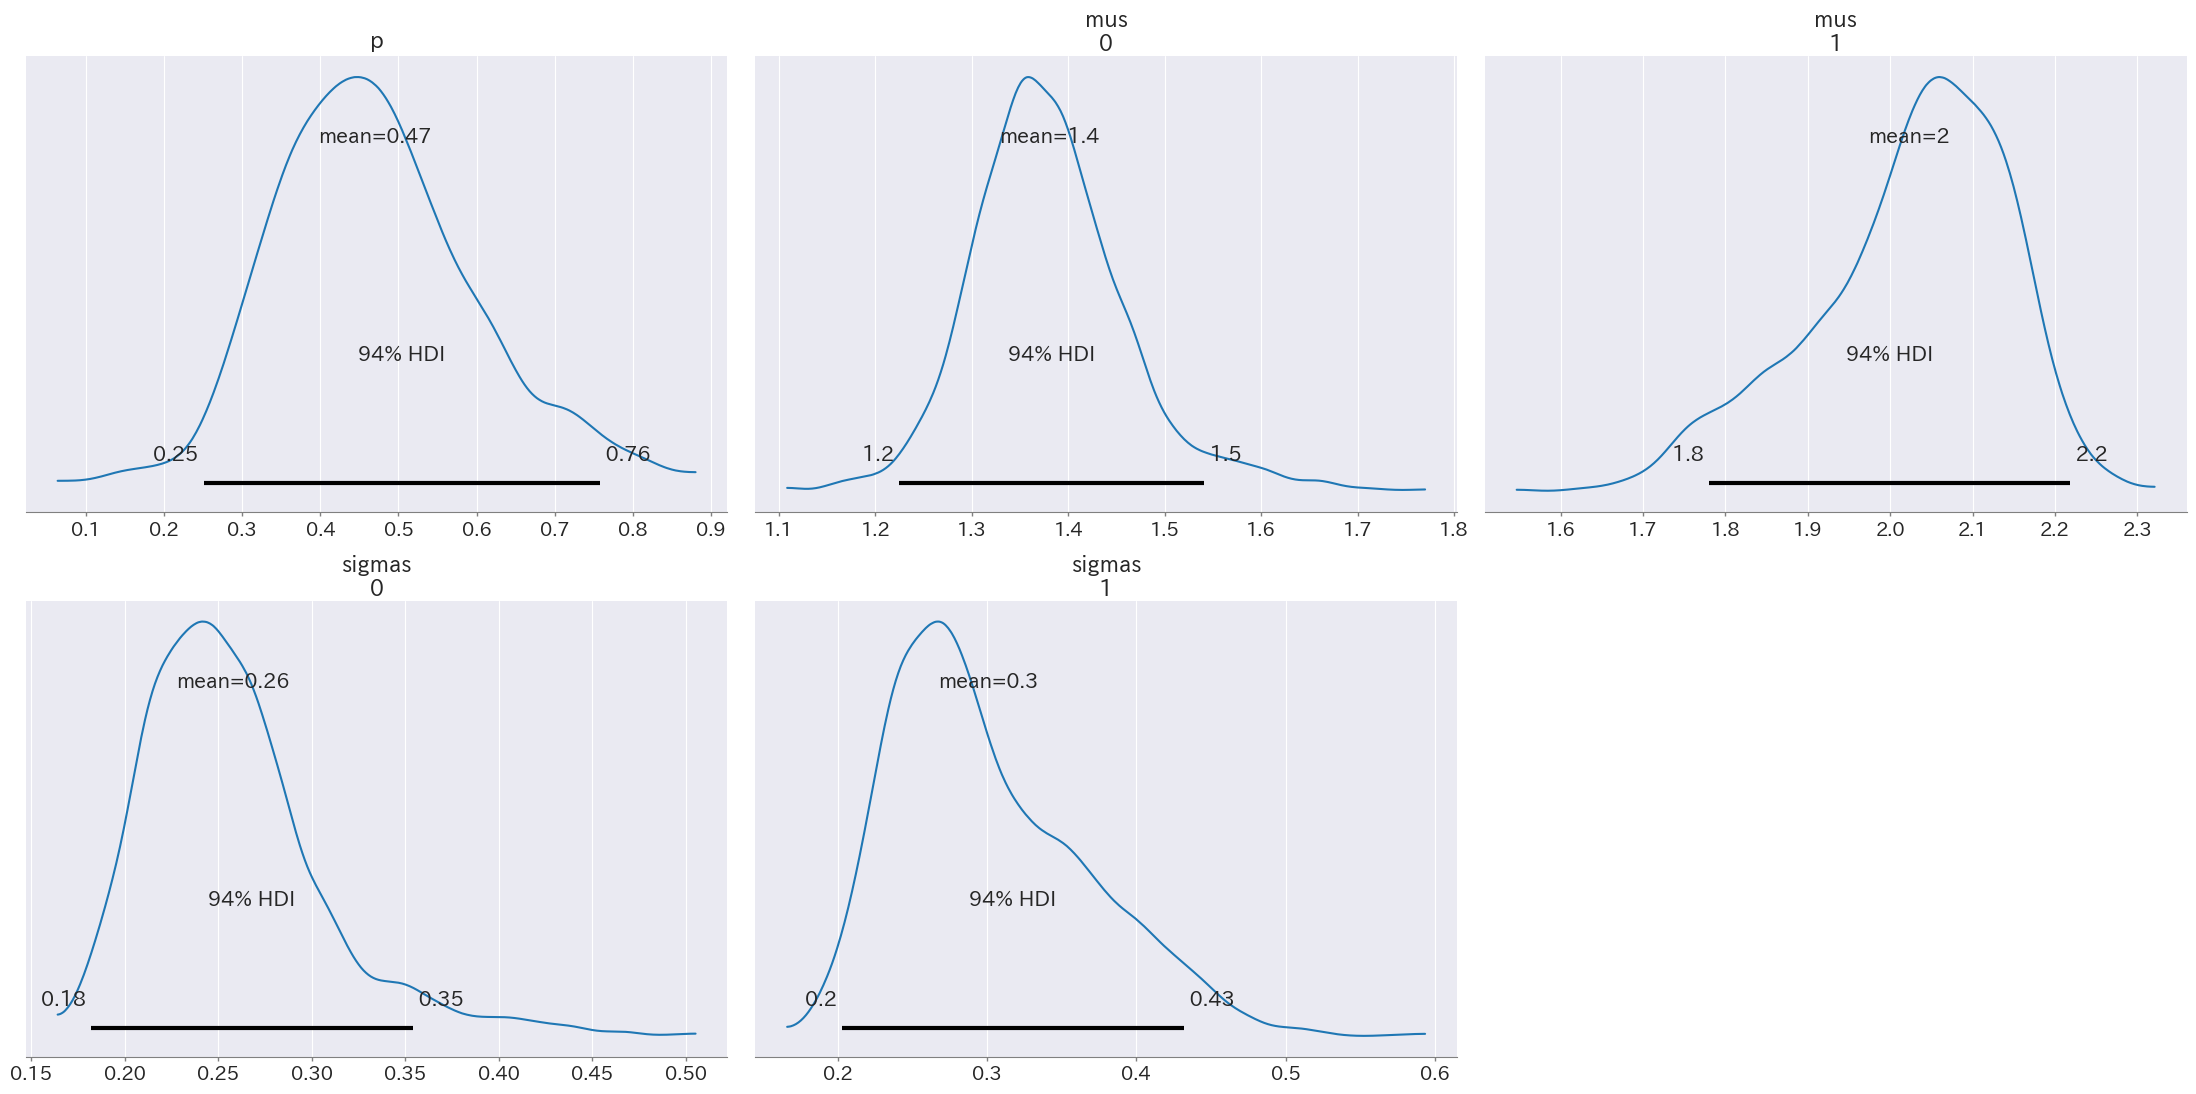

In [20]:
# 事後分布の可視化
az.plot_posterior(inference_latent_variables, var_names=['p', 'mus', 'sigmas'])
plt.tight_layout()
plt.show()

- $p$ : ほぼ 0.5程度と妥当な値
- `mus` は、それぞれの要素の予測値で被りなく、きれいに分離できている。

In [22]:
# 統計分析
summary_latent_variables = az.summary(inference_latent_variables, var_names=['p', 'mus', 'sigmas'])
summary_latent_variables

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.469,0.134,0.251,0.758,0.013,0.009,105.0,210.0,NaN
mus[0],1.380,0.082,1.225,1.541,0.008,0.006,114.0,88.0,NaN
mus[1],2.023,0.119,1.780,2.218,0.012,0.008,107.0,263.0,NaN
sigmas[0],0.258,0.049,0.182,0.354,0.005,0.004,129.0,114.0,NaN
sigmas[1],0.301,0.065,0.203,0.432,0.006,0.005,105.0,272.0,NaN


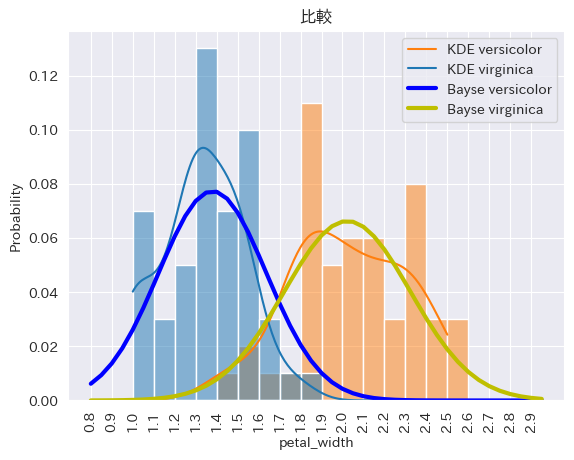

In [30]:
# お題のヒストグラムとベイズ推論から作成した分布の比較
means = summary_latent_variables['mean']  # 各パラメータの平均値
mean_mu_0 = means['mus[0]'] 
mean_mu_1 = means['mus[1]']
mean_sigma_0 = means['sigmas[0]']
mean_sigma_1 = means['sigmas[1]']
# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.1
y_0 = norm.pdf(x, mean_mu_0, mean_sigma_0) * delta / n_components
y_1 = norm.pdf(x, mean_mu_1, mean_sigma_1) * delta / n_components
# 描画
bins = np.arange(0.8, 3.0, delta)
fig, ax = plt.subplots()
sns.histplot(data=df_others, bins=bins, x='petal_width', hue='species', kde=True, ax=ax, stat='probability')
ax.get_lines()[0].set_label('KDE versicolor')
ax.get_lines()[1].set_label('KDE virginica')
ax.plot(x, y_0, c='b', lw=3, label='Bayse versicolor')
ax.plot(x, y_1, c='y', lw=3, label='Bayse virginica')
ax.set_xticks(bins)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title('比較')
plt.legend()
plt.show()

花の種別の情報なしにベイズ推論した結果が KDEによる近似曲線とほぼ一致。   
ベイズ推論により予測が正しく行われた。